# Оптимизация производственного процесса легирования стали

## О проекте

### Цель

Разработка модели, позволяющей снизить затраты на процесс легирования стали путем снижения энергопотребления

### Задача

На имеющихся исторических данных построить модель, которая будет прогнозировать температуру конечного расплава в зависимости от заданных параметров производственного процесса. Оптимизация достигается путем снижения энергозатрат за счёт предварительного подбора оптимальных условий легирования.

### Краткое описание производственного процесса

Сталь обрабатывают в огнеупорном ковше вместимостью около 100 тонн. Расплав заливают в объем и подогревают до нужной температуры графитовыми электродами, установленными в крышке ковша. </br>

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. После этого начинается процесс легирования путем подачи  кусков сплава из бункера для сыпучих материалов или проволоки через специальный трайб-аппарат.</br>

Перед началом легирования измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. </br>

Этот цикл повторяют до достижения целевого химического состава и оптимальной температуры плавки. После этого расплав отправляется на следующий этап.</br>
</br>
В рамках нашей задачи целевым является сам этап легирования: с помощью модели можно будет планировать подачу материалов и степень нагрева для достижения оптимальной температуры с минимальными затратами мощности.

### Доступные данные

Для работы доступны следующие файлы с данными:
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Столбец 'key' во всех столбцах содержит номер партии. Обработка партий в ковше происходит последовательно. </br>
Также мы знаем, что температура в процессе легирования не должна опускаться ниже 1500 С, иначе партия считается производственным браком.

### План работы

- **Знакомство с данными и предобработка**</br>
    Изучение содержимого файлов, предварительная обработка для удобства дальнейшей работы.</br></br>
- **Исследовательский анализ данных**</br>
    Изучение распределения данных и взаимосвязей между ними, поиск аномалий и некорректных данных. Агрегрирование и объединение таблиц. Изучение целевого признака.</br></br>
- **Подготовка данных**</br>
    Отбор признаков и генерация новых, проверка на мультиколлинеарность, разбиение на обучающую и тестовую выборки.</br> </br>
- **Обучение моделей, подбор параметров, выбор модели**</br>
    Выбор моделей и подбор гиперпараметров, изучение метрик и выбор лучшей модели.</br></br>
- **Финальное тестирование**</br>
    Проверка выбранной модели на тестовой выборке.</br></br>
- **Выводы**</br></br>
- **Итоговый отчет**

## Знакомство с данными и предобработка

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor

In [2]:
#определим константы

RANDOM_SEED = 11122

### Краткий обзор данных

Откроем файлы данных и изучим основную информацию

In [3]:
try:
    data_arc = pd.read_csv('datasets/data_arc.csv')
    data_bulk = pd.read_csv('datasets/data_bulk.csv')
    data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
    data_gas = pd.read_csv('datasets/data_gas.csv')
    data_temp = pd.read_csv('datasets/data_temp.csv')
    data_wire = pd.read_csv('datasets/data_wire.csv')
    data_wire_time = pd.read_csv('datasets/data_wire_time.csv')
except FileNotFoundError:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [4]:
display(data_arc.info(), data_arc.describe(), data_arc.head())
print('Уникальных номеров партии в датасете:', data_arc['key'].nunique())
print('Явных дубликатов:', data_arc.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Уникальных номеров партии в датасете: 3214
Явных дубликатов: 0


In [5]:
display(data_temp.info(), data_temp.describe(), data_temp.head())
print('Уникальных номеров партии в датасете:', data_temp['key'].nunique())
print('Явных дубликатов:', data_temp.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Уникальных номеров партии в датасете: 3216
Явных дубликатов: 0


In [6]:
display(data_bulk.info(), data_bulk.describe(), data_bulk.head())
print('Уникальных номеров партии в датасете:', data_bulk['key'].nunique())
print('Явных дубликатов:', data_bulk.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Уникальных номеров партии в датасете: 3129
Явных дубликатов: 0


In [7]:
display(data_bulk_time.info(), data_bulk_time.head())
print('Уникальных номеров партии в датасете:', data_bulk_time['key'].nunique())
print('Явных дубликатов:', data_bulk_time.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Уникальных номеров партии в датасете: 3129
Явных дубликатов: 0


In [8]:
display(data_wire.info(), data_wire.describe(), data_wire.head())
print('Уникальных номеров партии в датасете:', data_wire['key'].nunique())
print('Явных дубликатов:', data_wire.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальных номеров партии в датасете: 3081
Явных дубликатов: 0


In [9]:
display(data_wire_time.info(), data_wire_time.describe(), data_wire_time.head())
print('Уникальных номеров партии в датасете:', data_wire_time['key'].nunique())
print('Явных дубликатов:', data_wire_time.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальных номеров партии в датасете: 3081
Явных дубликатов: 0


In [10]:
display(data_gas.info(), data_gas.describe(), data_gas.head())
print('Уникальных номеров партии в датасете:', data_gas['key'].nunique())
print('Явных дубликатов:', data_gas.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Уникальных номеров партии в датасете: 3239
Явных дубликатов: 0


**Промежуточный вывод**</br></br>
В нашем распоряжении 7 файлов с данными с информацией о производственном процессе легирования.</br>
В данных есть пропуски, колонки с датой и временем имеют тип object, а часть названий содержит заглавные буквы, пробелы и кириллицу. Явных дубликатов в данных нет.</br></br>

**data_arc** содержит информацию об эпизодах нагрева 3214-ти партий расплава (начало и конец), а также о мощности, затраченной на этот процесс. Мощность разбита на активную (т.е. отвечающую за нагрев) и реактивную. Активная мощность варьируется в диапазоне от 0.03 до 3.73 *единиц измерения*, при этом медиана 0.55 смещена влево относительно среднего 0.67, что указывает на большое количество небольших догревов в процессе легирования. Вероятно предполагается, что построенная модель позволит улучшить эту методику работы.</br>
Есть очевидная аномалия в виде отрицательной реактивной мощности в -715 единиц.</br></br>

**data_temp** содержит данные о времени и результатах измерения температуры стали для каждой партии, всего 15907 замеров на 3216 партий. При этом в результатах замеров есть около 3000 пропущенных значений.</br>
Температура варьируется от 1191 градуса до 1705, средняя и медиана почти полностью совпадают.</br>
</br>
**data_bulk** - информация о том, какой объем материала был подан в расплав из каждого из 15ти "бункеров" (вероятно, содержащих материалы разного химсостава). </br>
В файле много пропусков (в некоторых столбцах - 90% и более), скорее всего они означают, что из данного бункера в данную партию материал не поступал. Доступны данные о 3129 партиях.</br></br>

**data_bulk_time** содержит данные о времени подачи материалов из 'data_bulk'.</br></br>

**data_wire** - данные о подаче легирующих материалов в виде проволоки из 9-ти различных трайбов. Как и 'data_bulk' содержит много пропусков (90% и более в некоторых столбцах), которые означают, что материал не подавался. Доступны записи о 3081 партии.</br></br>
**data_wire_time** - время подачи образцов из data_wire.</br></br>

**data_gas** - информация о номере партии (3239 партий) и общем объеме поданного газа. Объем варьируется от 0.008 до 77.99 со средним значением в 11.00 и медианой в 9.8, что означет, что большие объемы поданного газа случаются редко и, вероятно, связаны с многократным повторением легирования в попытке достигнуть нужных параметров.

### Переименование столбцов

In [11]:
#переименуем столбцы для удобства работы

data_arc.columns = ['key', 'heating_start', 'heating_fin', 'active_power', 'reactive_power']
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_gas.columns = ['key', 'gas']

In [12]:
#создадим функцию для переименования нумерованых столбцов с общим названием

def rename_func(n, name):
    list_of_columns = ['key']
    for i in range (1, n+1): list_of_columns.append(name + str(i))
    return list_of_columns

In [13]:
#переименуем оставшиеся датафреймы

data_bulk.columns = rename_func(15, 'bulk_')
data_bulk_time.columns = rename_func(15, 'bulk_time_')
data_wire.columns = rename_func(9, 'wire_')
data_wire_time.columns = rename_func(9, 'wire_time_')

### Преобразование типов данных

In [14]:
#все колонки со временем приведем к соответствующему типу данных

data_arc.iloc[:, 1:3] = data_arc.iloc[:, 1:3].apply(pd.to_datetime)
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time.iloc[:, 1:15] = data_bulk.iloc[:, 1:15].apply(pd.to_datetime)
data_wire_time.iloc[:, 1:9] = data_wire.iloc[:, 1:9].apply(pd.to_datetime)

Обработка пропусков (временный раздел)

Обработка пропусков для data_temp проводится в процессе исследовательского анализа. </br>
Обработка пропусков в data_bulk и data_wire будет сделана на этапе подготовки данных, т.к. изучать данные о распределении разреженных данных гораздо удобнее без нулей. </br>
data_bulk_time и data_wire_time ипользовать не будем, поэтому там обработку пропусков делать нет смысла.

In [15]:
#заменяем пропуски в bulk и wire нулями

#data_bulk = data_bulk.fillna(0)
#data_bulk_time = data_bulk_time.fillna(0)
#data_wire = data_wire.fillna(0)
#data_wire_time = data_wire_time.fillna(0)

### Промежуточные выводы

У нас есть данные о процессах легирования 3000+ партий стали. Мы рассмотрели их основные параметры и сделали предварительную обработку для удобства работы. Поскольку все данные разнесены по разным файлам, требуется тщательный EDA, чтобы определить, насколько они соотносятся друг с другом, какая подготовка требуется и какую часть этих данных возможно использовать для построения модели.

## Исследовательский анализ данных

### Замеры температуры

Сначала рассмотрим данные о замерах температуры, содержащие целевой признак - конечную температуру расплава.

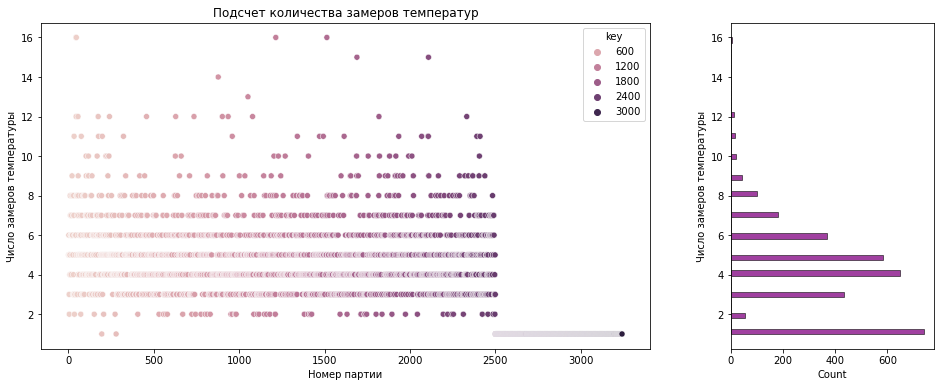

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw={'width_ratios': [3, 1]})
sns.scatterplot(data=data_temp.groupby('key', as_index=False).count(), x='key', y='temperature', hue='key', ax=ax1);
ax1.set(title='Подсчет количества замеров температур', xlabel='Номер партии', ylabel='Число замеров температуры')
ax2.set(xlabel='Count', ylabel='Число замеров температуры')
sns.histplot(data=data_temp.groupby('key', as_index=False).count(), y='temperature', color='purple', ax=ax2);
plt.show()

Количество замеров температуры сильно варьируется от партии к партии - где-то их 2, где-то 16. Вероятно, многократные измерения соответствуют многократному нагреву расплава и именно эту ситуацию нам предстоит оптимизировать.</br>
</br>
Для примера посмотрим число нагревов для партий с 16ю измерениями температур:

In [17]:
(data_arc[data_arc['key'].isin(data_temp.groupby('key').count().query('temperature == 16').index)]
  .groupby('key').count()['active_power'])

key
44      12
46      13
1214     3
1513    15
Name: active_power, dtype: int64

Уточним, что там с партией 1214.

In [18]:
display(data_arc[data_arc['key'] == 1214])
data_temp[data_temp['key'] == 1214]

,key,heating_start,heating_fin,active_power,reactive_power
5583,1214,2019-06-16 05:26:17,2019-06-16 05:27:47,0.330679,0.242518
5584,1214,2019-06-16 05:43:10,2019-06-16 05:48:39,1.211347,0.859486
5585,1214,2019-06-16 05:56:24,2019-06-16 05:57:26,0.264106,0.146743


,key,measurement_time,temperature
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0
5982,1214,2019-06-16 05:52:41,1608.0
5983,1214,2019-06-16 05:53:03,1608.0
5984,1214,2019-06-16 05:53:13,1608.0
5985,1214,2019-06-16 05:54:48,1604.0
5986,1214,2019-06-16 05:57:21,1604.0
5987,1214,2019-06-16 06:00:25,1604.0


Подогревов было мало, но их хватило, чтобы раскочегарить расплав и потом долго измерять температуру в ожидании нужной. Важный момент - начальная температура расплава < 1500 C, значит в дальшейнем эта партия будет исключена из рассмотрения.</br>
Рассматривать такие эпизоды отдельно не имеет смысла, однако мы убедились, что не всегда множество замеров соответствует множественному нагреву.

Заметную долю составляют партии с одним замером - эту часть данных мы не сможем использовать для решения задачи, поэтому можно сразу удалить их.

In [19]:
print('Доля партий с одним замером', len(data_temp.groupby('key').count().query('temperature <= 1')['temperature'])
                                     / data_temp['key'].nunique())

Доля партий с одним замером 0.23041044776119404


In [20]:
data_temp_updated = (data_temp[data_temp['key']
                     .isin(data_temp.groupby('key', as_index=False).count()
                     .query('temperature > 1')['key'])])

Построим гистограмму распределения температур

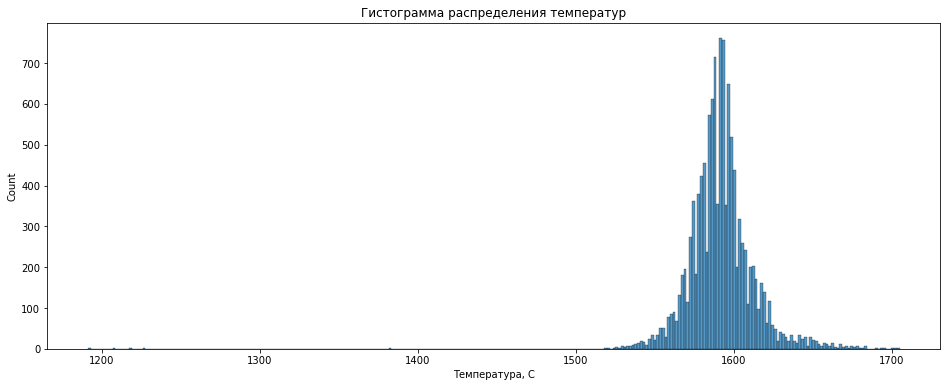

In [21]:
plt.figure(figsize=(16, 6))
sns.histplot(data=data_temp_updated, x='temperature');
plt.xlabel('Температура, С')
plt.title('Гистограмма распределения температур')
plt.show()

Она имеет выраженный хвост в область низких значений, но, как уже отмечалось, процессы с падениями температуры ниже 1500 С считаются выходящми за рамки технологических норм и не рассматриваются.</br>
Выведем на экран минимальную и максимальную темературы, а так же график измерения температур по времени.

In [22]:
print('Минимальная температура', data_temp_updated['temperature'].min())
print('Максимальная температура', data_temp_updated['temperature'].max())

Минимальная температура 1191.0
Максимальная температура 1705.0


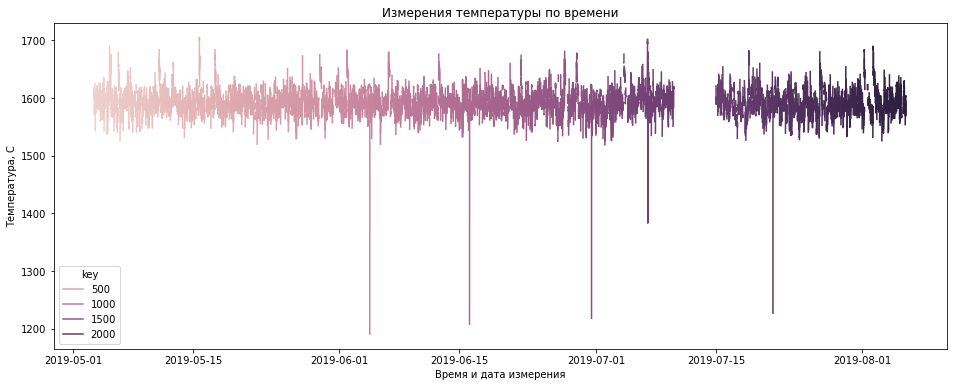

In [23]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=data_temp_updated, x='measurement_time', y='temperature', hue='key');
plt.xlabel('Время и дата измерения')
plt.ylabel('Температура, С')
plt.title('Измерения температуры по времени')
plt.show()

В датасете есть температуры заметно ниже 1500 С, но это единичные случаи - их нужно будет удалить.</br>
Также видно, что в работе оборудования был период простоя в середине июля. Видна неравномерность графика в начале августа.</br>
</br>
Укрупним начало августа, добавим маркеры на график.

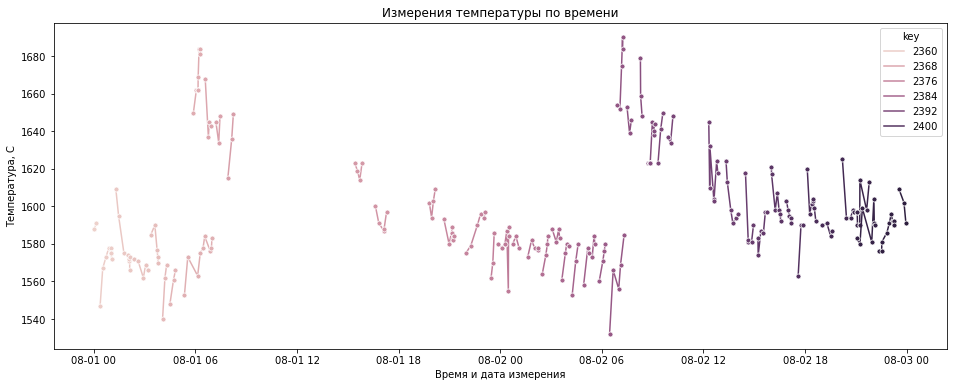

In [24]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=data_temp_updated.query('measurement_time > "2019-08-01" and measurement_time < "2019-08-03" '), 
             x='measurement_time', y='temperature', hue='key', marker= 'o', markersize=5);
plt.xlabel('Время и дата измерения')
plt.ylabel('Температура, С')
plt.title('Измерения температуры по времени')
plt.show()

Неравномерность на графике - это, по видимому, тоже перерывы в измерениях. Также видно, что некоторые серии измерений в датасете происходят параллельно. По нашей информации, обработки партий происходят строго последовательно, поэтому эту аномалию просто проигнорируем и будем рассматривать каждую партию изолированно.</br>
</br>
Для дальнейшей работы удалим информацию о партиях, при обработке которых температура опускалась ниже допустимного уровня.

In [25]:
data_temp_updated = (data_temp_updated.loc[~data_temp_updated['key'].isin(data_temp_updated
                     .query('temperature < 1500')['key'].drop_duplicates())])

### Целевой признак

In [26]:
#выведем информацию о получившемся датасете

data_temp_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12221 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12221 non-null  int64         
 1   measurement_time  12221 non-null  datetime64[ns]
 2   temperature       12221 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 381.9 KB


In [27]:
print('Количество партий в оставшихся данных:', data_temp_updated['key'].nunique())

Количество партий в оставшихся данных: 2470


В нем нет пропущенных значений, однако есть промежуточные измерения температуры, которые мы не будем включать в признаки.</br>
Таким образом, для дальшейшей работы нам необхоимо оставить по два значения температуры на каждую партию - начальное и конечное.

In [28]:
data_temp_first = data_temp_updated.sort_values('measurement_time').groupby('key', as_index=False).first()
print('Количество партий в данных о начальной температуре:', data_temp_first['key'].nunique())

Количество партий в данных о начальной температуре: 2470


In [29]:
data_temp_last = data_temp_updated.sort_values('measurement_time').groupby('key', as_index=False).last()
print('Количество партий в данных о начальной температуре:', data_temp_last['key'].nunique())

Количество партий в данных о начальной температуре: 2470


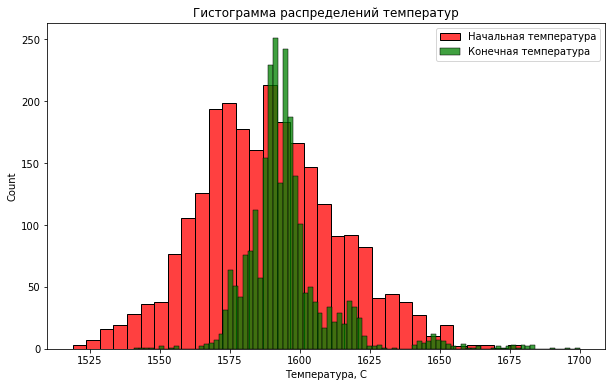

In [30]:
plt.figure(figsize = (10, 6))
sns.histplot(data=data_temp_first, x='temperature', color='red', label='Начальная температура');
sns.histplot(data=data_temp_last, x='temperature', color='green', label='Конечная температура');
plt.xlabel('Температура, С')
plt.title('Гистограмма распределений температур')
plt.legend()
plt.show()

Начальные температуры расплавов имеют достаточно широкое распределение, а затем, после легирования эти распределения собираются в узкое бимодальное (возможно - тримодальное) распределение возле двух (трех) средних температур.

### Разогрев расплава

Изучим данные о разогреве расплава. </br>
</br>
Сначала удалим аномалию с отрицательной мощностью в датафрейме date_arc.

In [31]:
#удаляем строку с отрицательной реактивной мощностью

display(data_arc.query('reactive_power <= 0'))
data_arc = data_arc.query('reactive_power > 0')

,key,heating_start,heating_fin,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


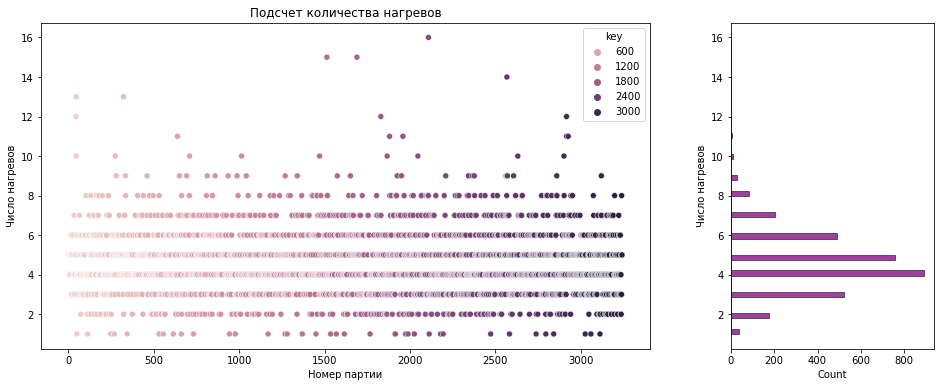

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw={'width_ratios': [3, 1]})
sns.scatterplot(data=data_arc.groupby('key', as_index=False).count(), x='key', y='active_power', hue='key', ax=ax1);
sns.histplot(data=data_arc.groupby('key', as_index=False).count(), y='active_power', color='purple', ax=ax2);
ax1.set(title='Подсчет количества нагревов', xlabel='Номер партии', ylabel='Число нагревов')
ax2.set(xlabel='Count', ylabel='Число нагревов')
plt.show()

Для некоторых партий достаточно было одного нагрева, для некоторых пришлось проходить более 10 итераций. Распределение числа нагревов похоже на нормальное с максимумом на значении 4. </br>
</br>
В таблице нам даны значения активной и реактивной мощности. 
Здесь полезную работу - нагрев расплава - выполняет только активная мощность, а реактивная играет роль своего рода издержек (поскольку оплачивает предприятие расход полной мощности).</br>
Посмотрим, как эти величины распределены и как связаны друг с другом.

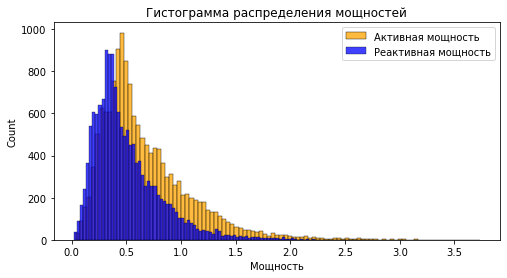

In [33]:
plt.figure(figsize = (8, 4))
sns.histplot(data=data_arc, x='active_power', color='orange', label='Активная мощность');
sns.histplot(data=data_arc, x='reactive_power', color='blue', label='Реактивная мощность');
plt.xlabel('Мощность')
plt.title('Гистограмма распределения мощностей')
plt.legend()
plt.show()

In [34]:
#добавим столбец с полной мощностью

data_arc['full_power'] = (data_arc['active_power'] **2 + data_arc['reactive_power']**2) ** 0.5

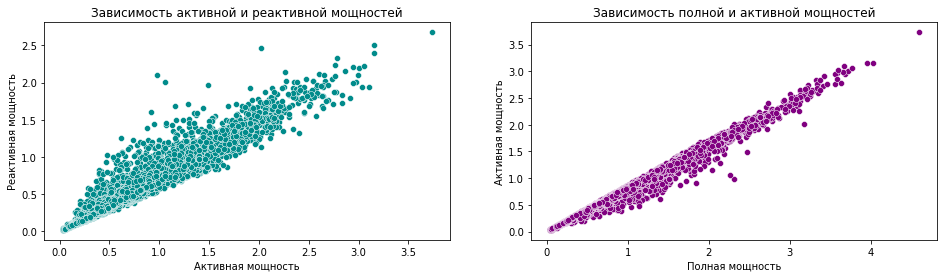

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))
sns.scatterplot(data=data_arc, x='active_power', y='reactive_power', color='darkcyan', ax=ax1);
sns.scatterplot(data=data_arc, x='full_power', y='active_power', color='purple', ax=ax2);
ax1.set(title='Зависимость активной и реактивной мощностей', xlabel='Активная мощность', ylabel='Реактивная мощность')
ax2.set(title='Зависимость полной и активной мощностей', xlabel='Полная мощность', ylabel='Активная мощность')
plt.show()

In [36]:
data_arc['active_power'].corr(data_arc['reactive_power'])

0.9631819131519801

Форма распределения реактивной мощности фактически повторяет активную мощность; корреляция между этими двумя значениями близка к единице - это очень хорошо видно на графике зависимости активной мощности от полной. Таким образом для дальнейших расчетов будем брать только активную мощность.</br>
</br>
Посчитаем длительность нагрева каждой партии и посмотрим, как это влияет на потребляемую мощность. А также выборочно посмотрим графики нагрева для некоторых партий.

In [37]:
data_arc['heating_time'] = data_arc['heating_fin'] - data_arc['heating_start']
data_arc['heating_time'] = data_arc['heating_time'].dt.seconds.astype('int32')

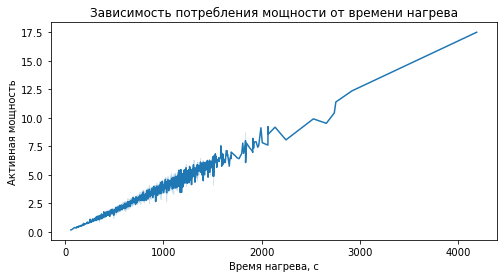

In [38]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=data_arc.groupby('key', as_index=False).sum(), x='heating_time', y='active_power');
plt.xlabel('Время нагрева, с')
plt.ylabel('Активная мощность')
plt.title('Зависимость потребления мощности от времени нагрева')
plt.show()

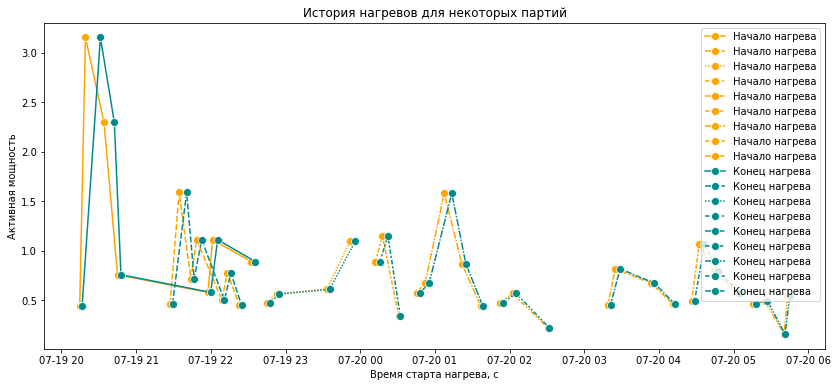

In [39]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=data_arc.query('key > 2000 and key < 2010'), x='heating_start', y='active_power', color='orange', 
             style='key', marker= 'o', markersize=8, label='Начало нагрева', legend=False);
sns.lineplot(data=data_arc.query('key > 2000 and key < 2010'), x='heating_fin', y='active_power', color='darkcyan',
            style='key', marker= 'o', markersize=8, label='Конец нагрева', legend=False);
plt.xlabel('Время старта нагрева, с')
plt.ylabel('Активная мощность')
plt.title('История нагревов для некоторых партий')
plt.legend(loc='upper right')
plt.show()

Зависимость между временем нагрева партии и затраченной мощностью довольно логичная - дольше нагрев, больше мощность. </br>
Однако на графике с историями нагрева отдельных партий видно, что между концом одного прогрева и началом другого могло пройти достаточно больше время, в течение которого расплав остывал. При генерации фич в дальнейшем стоит также попробовать учесть время простоя между нагревами.

In [40]:
#подготовим данные для объединения, исключая попутно колонки с датами

data_arc_grouped = data_arc.groupby('key', as_index=False).sum()
data_arc_grouped.head()

,key,active_power,reactive_power,full_power,heating_time
0,1,4.878147,3.183241,5.826395,1098
1,2,3.052598,1.998112,3.649216,811
2,3,2.525882,1.599076,2.989534,655
3,4,3.209250,2.060298,3.814962,741
4,5,3.347173,2.252643,4.035758,869


### Сыпучие материалы

В данных о сыпучих материалах много пропусков - это связано с тем, что для подачи материалов в производственном процессе используется 15 бункеров (вероятно, с добавками различного состава) и при легировании каждой партии задействуется лишь несколько.</br>
Такая подача удобна для построения графиков - значения N\a просто не учитываются. Однако для дальнейшей работы пропуски придется ликвидировать.</br>
Изучим информацию о распределении сыпучих материалов.

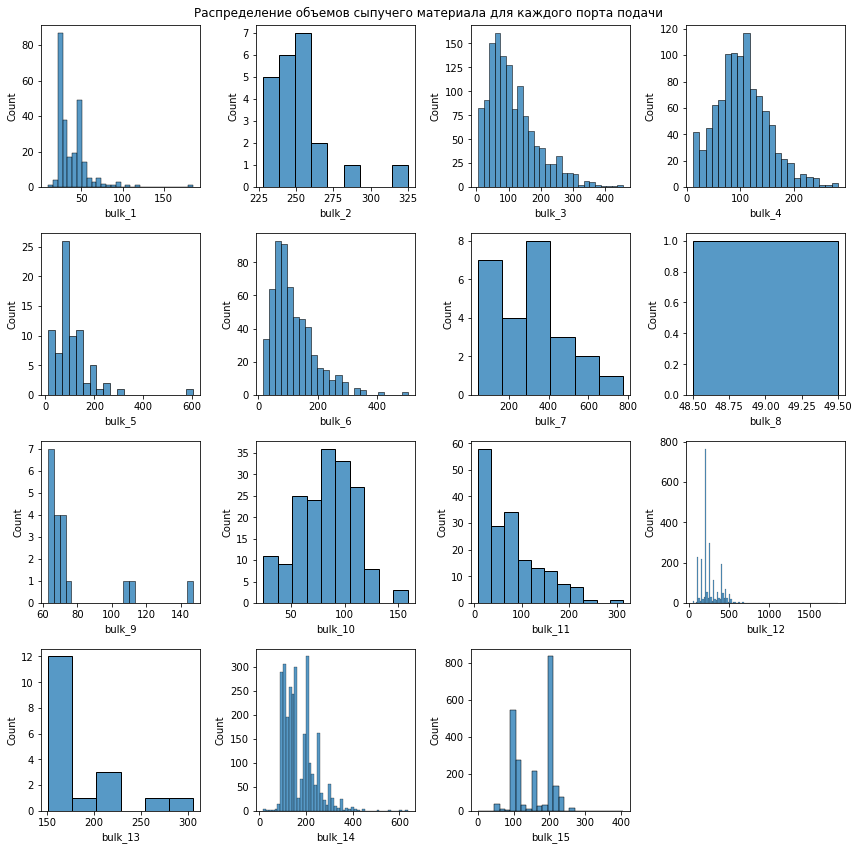

In [41]:
fig = plt.figure(figsize=(12, 12))
plt.suptitle('Распределение объемов сыпучего материала для каждого порта подачи')
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    sns.histplot(data=data_bulk.set_index('key').iloc[:, i])
    
fig.tight_layout()
plt.show()

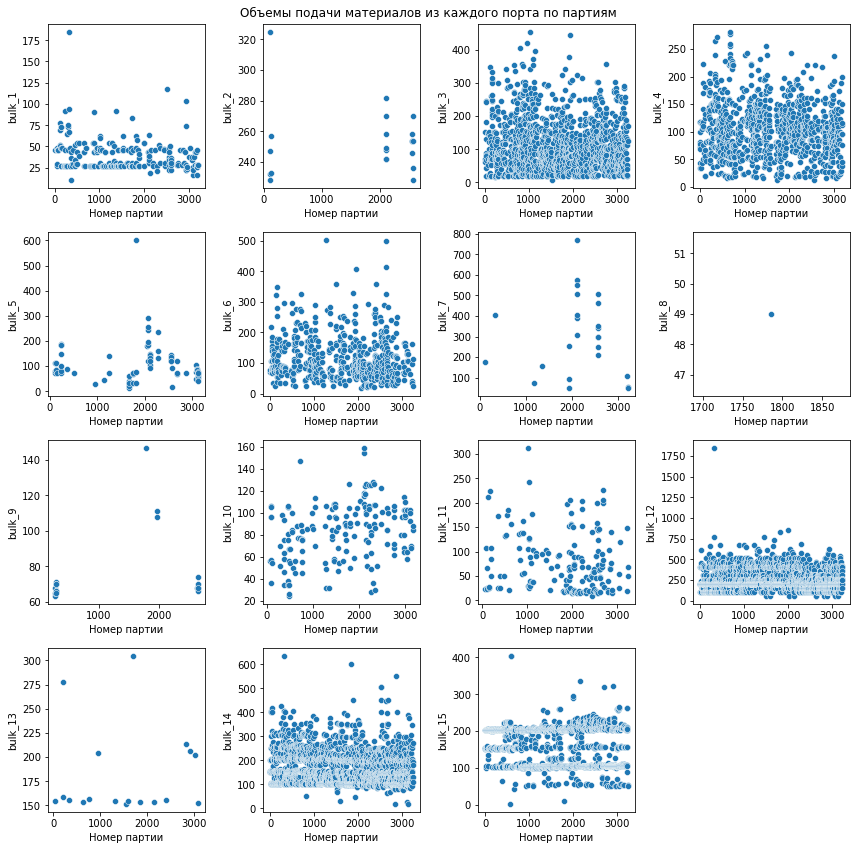

In [42]:
fig = plt.figure(figsize=(12,12))
plt.suptitle('Объемы подачи материалов из каждого порта по партиям')
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    sns.scatterplot(data=data_bulk.set_index('key').iloc[:, i])
    plt.xlabel('Номер партии')
    
fig.tight_layout()
plt.show()

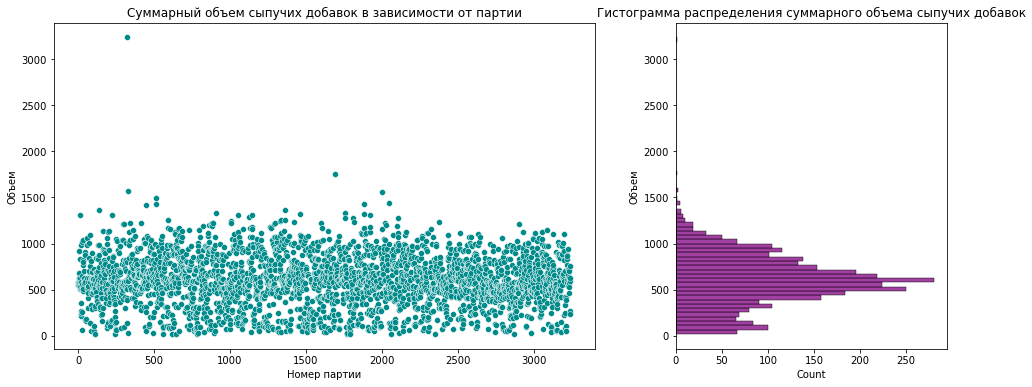

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw={'width_ratios': [2, 1]})
sns.scatterplot(data=data_bulk.set_index('key').sum(axis=1), color='darkcyan', ax=ax1);
sns.histplot(y=data_bulk.set_index('key').sum(axis=1), color='purple', ax=ax2);
ax1.set(title='Суммарный объем сыпучих добавок в зависимости от партии', xlabel='Номер партии', ylabel='Объем')
ax2.set(title='Гистограмма распределения суммарного объема сыпучих добавок', ylabel='Объем', xlabel='Count')
plt.show()

Видим, что одни бункеры оказываются задействованы почти во всех партиях, а другие - в очень небольшом количестве. Бункер 8 вообще используется один раз из всех 3000+ процессов легирования. В данных нет партий с нулевым объемом добавок (их пришлось бы исключить), но есть партии с очень низким суммарным объемом легирования. Общий объем легирования достаточно стабилен для всех партий и в среднем составляет около 600-700 (кг?)

Файл data_bulk_time содержит лишь информацию о временных метках. </br>
Для решения задачи нам важен объем и номер порта подачи материала, поэтому временные метки мы не будем использовать. На всякий случай убедимся, что между файлом с объемом и метками есть полное соответствие - посчитаем число событий для каждой партии, найдем разность и просуммируем по всему файлу. При отсутствии расхождений получим 0.

In [44]:
(data_bulk.set_index('key').count(axis=1) - data_bulk_time.set_index('key').count(axis=1)).sum()

0

### Проволочные материалы

Для получения информации о расходовании проволочных материалов при легировании, построим для этих данных те же графики и гистограммы, что и для сыпучих добавок.

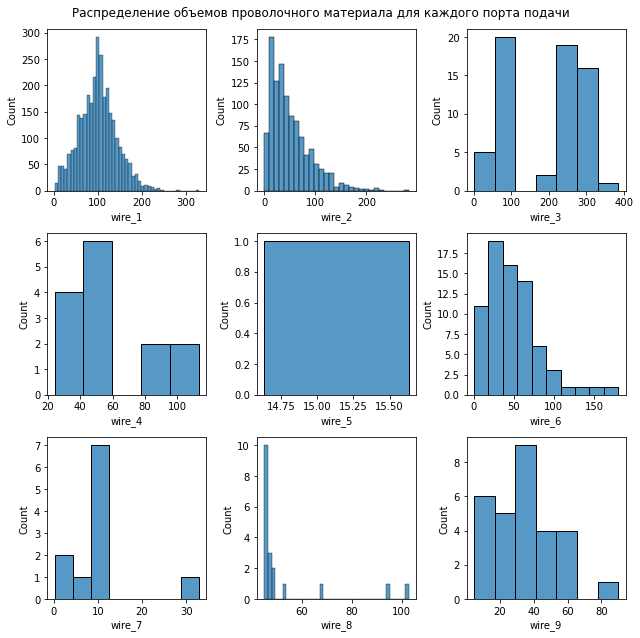

In [45]:
fig = plt.figure(figsize=(9, 9))
plt.suptitle('Распределение объемов проволочного материала для каждого порта подачи')
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    sns.histplot(data=data_wire.set_index('key').iloc[:, i])
    
fig.tight_layout()
plt.show()

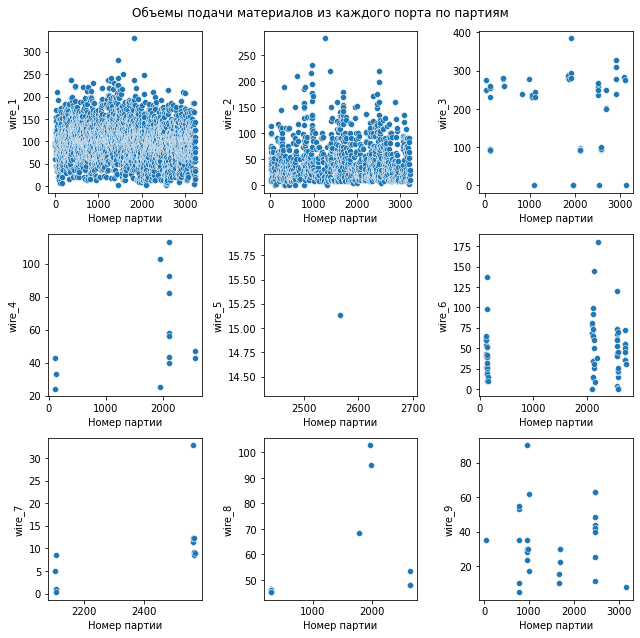

In [46]:
fig = plt.figure(figsize=(9, 9))
plt.suptitle('Объемы подачи материалов из каждого порта по партиям')
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    sns.scatterplot(data=data_wire.set_index('key').iloc[:, i])
    plt.xlabel('Номер партии')
    
fig.tight_layout()
plt.show()

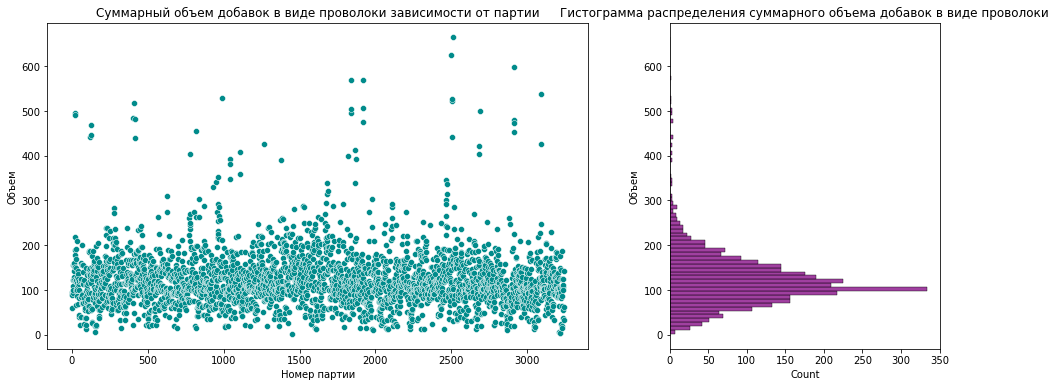

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw={'width_ratios': [2, 1]})
sns.scatterplot(data=data_wire.set_index('key').sum(axis=1), color='darkcyan', ax=ax1);
sns.histplot(y=data_wire.set_index('key').sum(axis=1), color='purple', ax=ax2);
ax1.set(title='Суммарный объем добавок в виде проволоки зависимости от партии', xlabel='Номер партии', ylabel='Объем')
ax2.set(title='Гистограмма распределения суммарного объема добавок в виде проволоки', ylabel='Объем', xlabel='Count')
plt.show()

In [48]:
#проверяем соответствие данных по объему и меткам времени

(data_wire.set_index('key').count(axis=1) - data_wire_time.set_index('key').count(axis=1)).sum()

0

Ситуация похожа на сыпучие материалы - два трайба с проволокой задействованы в большом количестве партий, остальные - в единичных случаях, а wire 5 используется всего один раз. Общее количество подаваемой проволоки достаточно стабильно от партии к партии, но случаев, когда ее больше среднего - больше, чем в ситуации с сыпучими материалами.</br>
Вероятно, ситуации с большим расходом легирующего материала могут быть связаны с многократным нагревом и, соответственно, бОльшим расходом мощности. Этот момент будет более очевиден после объединения таблиц.

### Газ

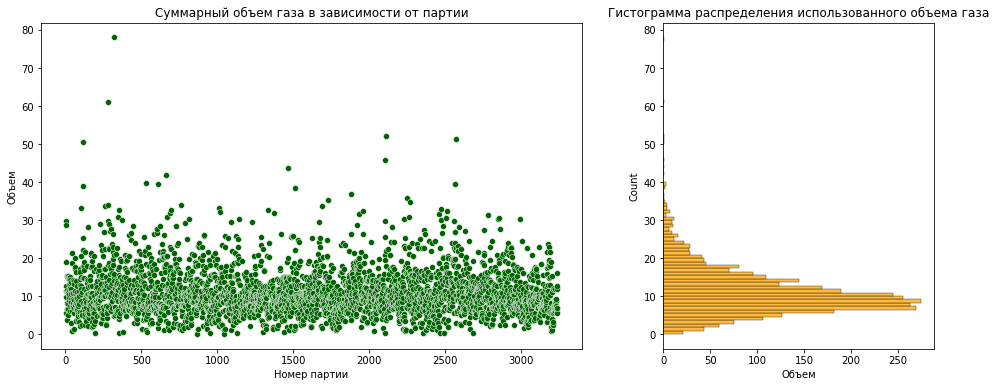

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw={'width_ratios': [2, 1]})
sns.scatterplot(data=data_gas, x='key', y='gas', color='darkgreen', ax=ax1);
sns.histplot(data=data_gas, y='gas', color='orange', ax=ax2);
ax1.set(title='Суммарный объем газа в зависимости от партии', xlabel='Номер партии', ylabel='Объем')
ax2.set(title='Гистограмма распределения использованного объема газа', xlabel='Объем', ylabel='Count')
plt.show()

Газ также расходуется довольно стабильно за исключением отдельных выбросов. 

### Объединение таблиц

Для начала выведем на экран длины таблиц, которые мы будем объединять (они все агрегированы по ключу - колонке 'key')

In [50]:
print(len(data_arc_grouped), len(data_bulk), len(data_wire), len(data_gas), len(data_temp_first), len(data_temp_last))

3214 3129 3081 3239 2470 2470


Таким образом, в результирующей таблице не должно быть более 2470 записей.</br>
Проведем последовательное объединение данных с промежуточным выводом длины получившегося файла

In [51]:
data_merged = pd.merge(data_arc_grouped, data_bulk, on='key', how='inner')
print(len(data_merged))
data_merged = pd.merge(data_merged, data_wire, on='key', how='inner')
print(len(data_merged))
data_merged = pd.merge(data_merged, data_gas, on='key', how='inner')
print(len(data_merged))
data_merged = pd.merge(data_merged, data_temp_first, on='key', how='inner')
print(len(data_merged))
data_merged = pd.merge(data_merged, data_temp_last, on='key', how='inner')
print(len(data_merged))

3128
3024
3022
2325
2325


In [52]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 2325 non-null   int64         
 1   active_power        2325 non-null   float64       
 2   reactive_power      2325 non-null   float64       
 3   full_power          2325 non-null   float64       
 4   heating_time        2325 non-null   int32         
 5   bulk_1              199 non-null    float64       
 6   bulk_2              13 non-null     float64       
 7   bulk_3              958 non-null    float64       
 8   bulk_4              811 non-null    float64       
 9   bulk_5              53 non-null     float64       
 10  bulk_6              438 non-null    float64       
 11  bulk_7              13 non-null     float64       
 12  bulk_8              1 non-null      float64       
 13  bulk_9              13 non-null     float64     

У нас получилось 2325 записей и 34 колонки с данными, причем wire 5 (трайб с одной подачей) вообще выпал из итоговой таблицы, при формировании фич его нужно будет удалить.</br>

Создадим ще две колонки с суммарным объемом сыпучих и проволочных материалов и построим pairplot.

In [53]:
#считаем суммарный объем сыпучих и проволочных материалов

data_merged['bulk_volume'] = data_merged.loc[:, 'bulk_1':'bulk_15'].sum(axis=1)
data_merged['wire_volume'] = data_merged.loc[:, 'wire_1':'wire_9'].sum(axis=1)

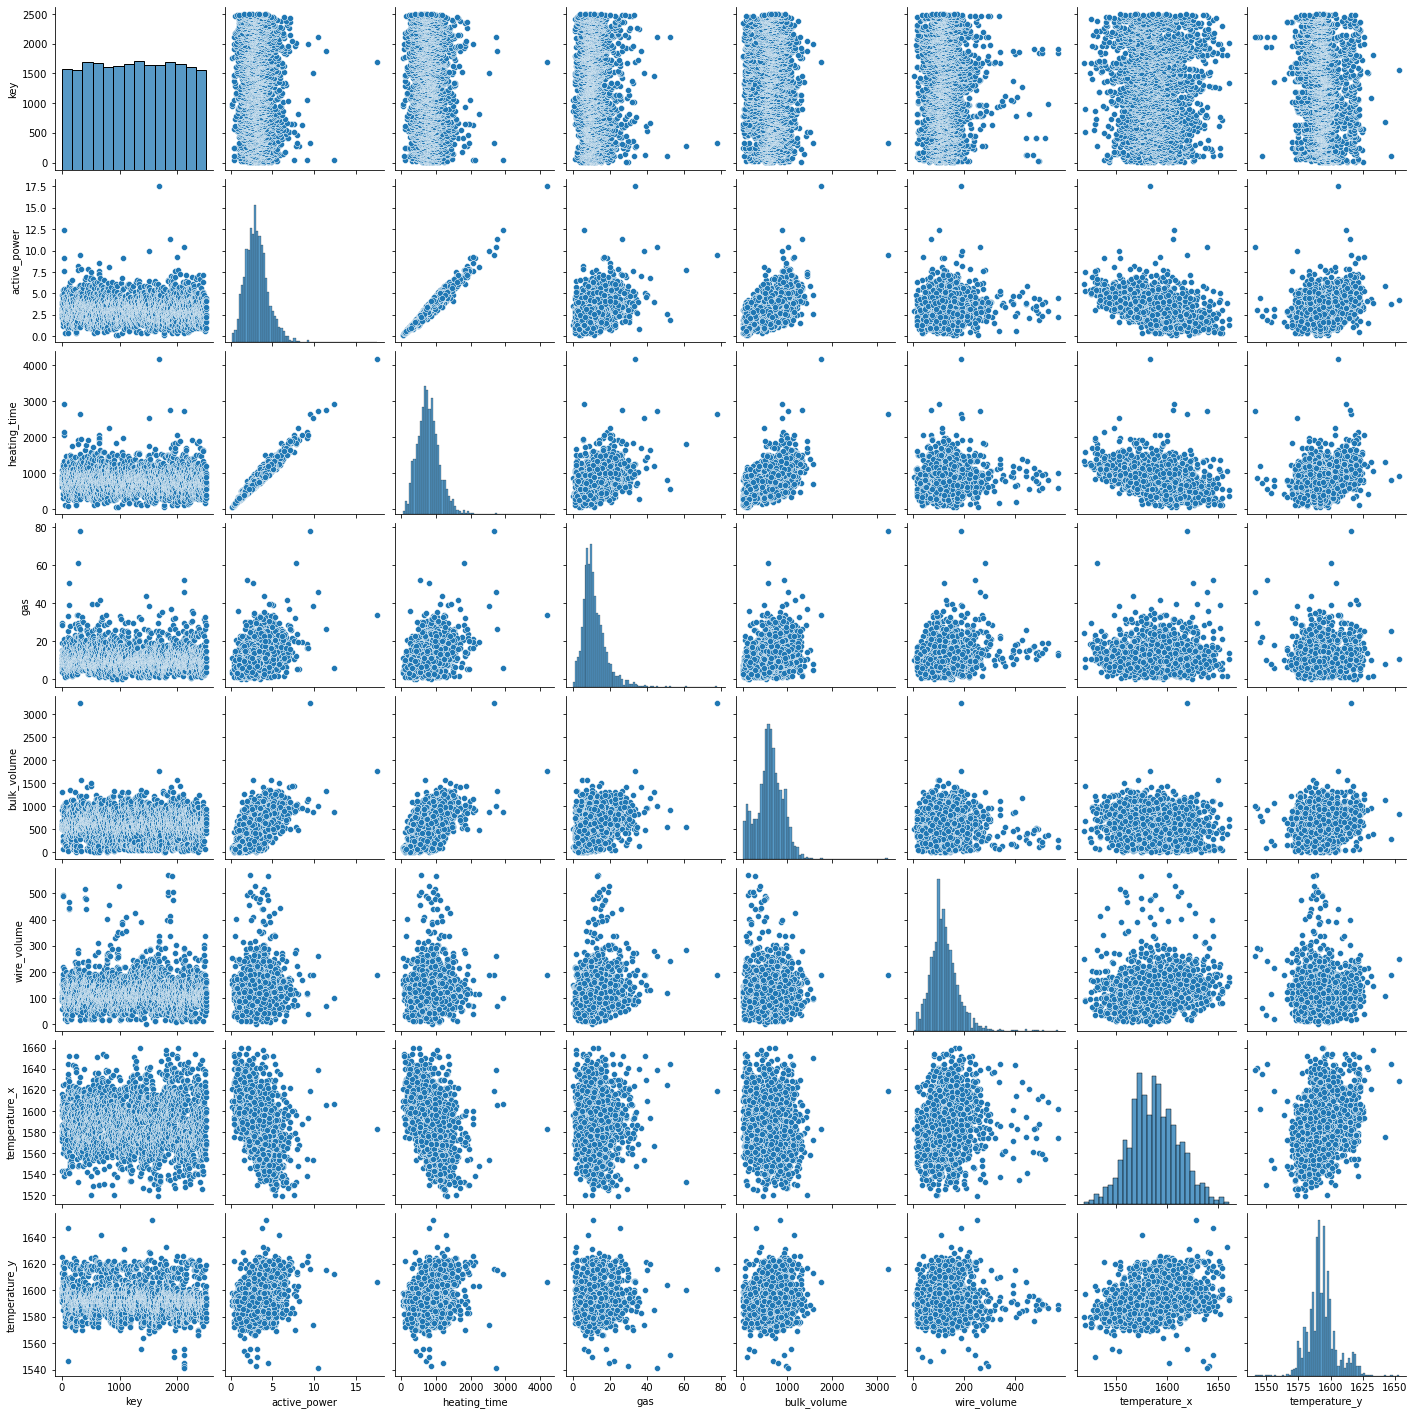

In [54]:
sns.pairplot(data=data_merged[['key', 'active_power', 'heating_time', 'gas', 'bulk_volume', 'wire_volume', 'temperature_x', 'temperature_y']]);

Пока очевидные зависимости на этом графике не заметны - за исключением величин active_power и time_delta. Зависимости других параметров от двух этих величинами фактически дублируют друг друга. Можно констатировать, что время нагрева и его мощность связаны линейно и смысла делать дополнительный признак из времени нагрева нет. </br>
</br>
Найдем разницу между финальной и начальной температурами и посмотрим, как это влияет на потребляемую мощность.

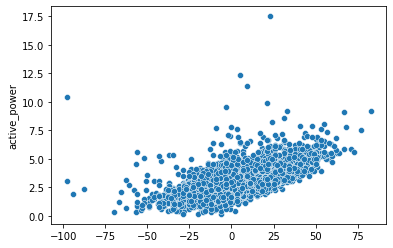

In [55]:
sns.scatterplot(data=data_merged, x=(data_merged['temperature_y']-data_merged['temperature_x']), y='active_power');

Можно сказать, что на графике есть некий тренд: чем больше разница - тем больше нужна мощность, чтобы ее достичь. Кроме того, на графике видно, что финальная температура может оказаться ниже начальной, несмотря на потраченную мощность - веозможно, в перерывах между прогревами расплаву дают остыть.

### Промежуточные выводы

Мы провели анализ полученных данных и обнаружили следующие особенности:
- количество измерений температуры, а также эпизодов нагрева для партии может варьироваться от 1 до 16 
- партии, которые содержат одно измерение температуры, пришлось исключить из рассмотрения ввиду недостаточности данных
- и начальная, и финальная температуры находятся в достаточно узком диапазоне от 1500 до 1704 С, при этом в соответствии с техзаданием пришлось исключить бракованные партии, в которых она опускалась ниже 1500 С.
- в файлах данных имеется фактическая рассинхронизация времён нагревов и замеров температур. Согласно уточнению от заказчика, этот фактор можно игнорировать, считая первый и последний замер температуры соответствующим началу и концу легировния
- согласно временным меткам легирование некоторых партий происходит параллельно - этот фактор мы также будем игнорировать, рассматривая каждую партию изолированно
- и сыпучие, и проволочные материалы из разных бункеров/трайбов используются неравномерно - одни добавляются в большое количество партий, другие - только в единицы
- суммарное время нагрева линейно связано с активной мощностью с коэффициентом корреляции 0,978
- в части случаев старотовая температура расплава оказывается выше, чем целевая

## Подготовка данных

Для разработки модели нам необходимо отобрать признаки, которые:
- позволят учесть все особенности производственного процесса
- позволят технологам планировать эксперимент заранее
- не будут дублировать друг друга

Использовать мы будем данные, из которых исключены партии с одним измерением температуры (они бесполезны для обучения и тестирования) и партии, в которых температура снижалась ниже 1500 С (это сочетание параметров, которое привело к браку).

Заказчик планирует оптимизировать энергопотребление - то есть активную мощность, которая затрачивается на процесс (реактивная мощность в данном случае - неизбежные издержки и ее оптимизация лежит за пределами решаемой задачи). Также необходимо учесть время остывания расплава, когда нагрев не идет, но процесс легирования еще не закончен (вероятно, в это время проводится анализ химсостава и корректировка добавок). 

Важно отметить, что величины активной и реактивной мощности это, как правило, измеряемые величины, а не регулируемые и их точное значение доступно уже по факту завершения процесса легирования. Можно запланировать потребить определенную мощность, но регулироваться в этом случае будут всё равно другие величины - сила тока, величину напряжения и (как в нашем случае) время нагрева. Поэтому логично включать в перечень признаков не саму мощность, а регулируемые параметры.

Выше мы видели, что активная мощность линейно зависит от чистого времени нагрева и мы можем это использовать. Таким образом, технолог сможет планировать эксперимент, включая в него предполагаемое время нагрева и предполагаемое время простоя для замеров (например, если по техпроцессу нельзя вводить все легирующие добавки разом).

Подготовим два набора, в один из которых войдет активная мощность, а в другой - чистое время нагрева.

Таким образом, в перечень признаков мы включим:
- данные о суммарном объеме сыпучих матералов, которые предполагается добавить к расплаву
- данные о суммарном объеме проволочных материалов
- данные об объеме газа, который будет использоваться для продувки
- начальную температуру расплава
- чистое время нагрева // активную мощность
- количество планируемых нагревов
- чистое время остывания 

Добавим в датасет data_arc_grouped время простоя - для каждой партии посчитаем время от начала первого нагрева до конца последнего и вычтем из него ранее посчитанное время чистого нагрева. Также добавим количество нагревов в каждой партии.

### Добавление признаков

Для каждой партии посчитаем полное время от начала первого нагрева и до завершения последнего, добавим его к сгрупированным данным и вычислим время остывания (полное - время нагрева).

In [56]:
data_arc_fulltime = (
    (data_arc.sort_values('heating_start').groupby('key').last()['heating_fin'] 
    - data_arc.sort_values('heating_start').groupby('key').first()['heating_start'])
    .dt.seconds.astype('int32')).reset_index()
data_arc_fulltime.columns = ['key', 'full_time']

In [57]:
data_arc_grouped = pd.merge(data_arc_grouped, data_arc_fulltime, on='key', how='inner')

In [58]:
data_arc_grouped['cool_down_time'] = data_arc_grouped['full_time'] - data_arc_grouped['heating_time']

In [59]:
data_arc_grouped.head()

,key,active_power,reactive_power,full_power,heating_time,full_time,cool_down_time
0,1,4.878147,3.183241,5.826395,1098,1583,485
1,2,3.052598,1.998112,3.649216,811,1144,333
2,3,2.525882,1.599076,2.989534,655,1525,870
3,4,3.209250,2.060298,3.814962,741,1093,352
4,5,3.347173,2.252643,4.035758,869,1362,493


### Формирование таблиц

Для двух наборов данных (с активной мощностью и временем) сформируем таблицы признаков путём последовательного объединения.

Предварительно заполним нули в таблицах с сыпучими и проволочными материалами.

In [60]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [61]:
data_ml = pd.merge(data_arc_grouped[['key', 'active_power', 'cool_down_time']], data_bulk, on='key', how='inner')
data_ml_time = pd.merge(data_arc_grouped[['key', 'heating_time', 'cool_down_time']], data_bulk, on='key', how='inner')

In [62]:
data_ml = pd.merge(data_ml, data_wire, on='key', how='inner')
data_ml_time = pd.merge(data_ml_time, data_wire, on='key', how='inner')

In [63]:
data_ml = pd.merge(data_ml, data_gas, on='key', how='inner')
data_ml_time = pd.merge(data_ml_time, data_gas, on='key', how='inner')

In [64]:
data_ml = pd.merge(data_ml, data_temp_first[['key', 'temperature']], on='key', how='inner')
data_ml_time = pd.merge(data_ml_time, data_temp_first[['key', 'temperature']], on='key', how='inner')

In [65]:
data_ml = pd.merge(data_ml, data_temp_last[['key', 'temperature']], on='key', how='inner')
data_ml_time = pd.merge(data_ml_time, data_temp_last[['key', 'temperature']], on='key', how='inner')

In [66]:
#смотрим, что получилось

data_ml.info(), data_ml_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2325 non-null   int64  
 1   active_power    2325 non-null   float64
 2   cool_down_time  2325 non-null   int32  
 3   bulk_1          2325 non-null   float64
 4   bulk_2          2325 non-null   float64
 5   bulk_3          2325 non-null   float64
 6   bulk_4          2325 non-null   float64
 7   bulk_5          2325 non-null   float64
 8   bulk_6          2325 non-null   float64
 9   bulk_7          2325 non-null   float64
 10  bulk_8          2325 non-null   float64
 11  bulk_9          2325 non-null   float64
 12  bulk_10         2325 non-null   float64
 13  bulk_11         2325 non-null   float64
 14  bulk_12         2325 non-null   float64
 15  bulk_13         2325 non-null   float64
 16  bulk_14         2325 non-null   float64
 17  bulk_15         2325 non-null   f

(None, None)

Удалим столбец wire_5, в котором не осталось данных, и столбец bulk_8, который использовался всего один раз.

In [67]:
data_ml = data_ml.drop(['wire_5', 'bulk_8'], axis=1)
data_ml_time = data_ml_time.drop(['wire_5', 'bulk_8'], axis=1)

Переименуем колонки и заполним пропуски нулями

In [68]:
data_ml = data_ml.rename(columns={'temperature_x': 'temperature_first', 'temperature_y': 'temperature_last'})
data_ml_time = data_ml_time.rename(columns={'temperature_x': 'temperature_first', 'temperature_y': 'temperature_last'})

In [69]:
#data_ml.fillna(0, inplace=True)
#data_ml_time.fillna(0, inplace=True)

Построим диаграммы корреляции для обоих наборов данных

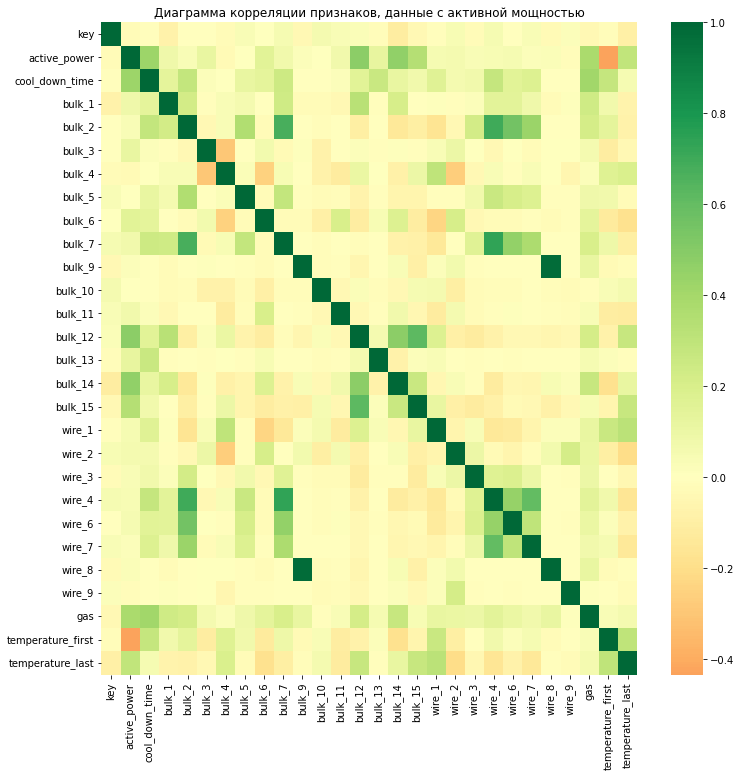

In [70]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_ml.corr(), xticklabels=data_ml.corr().columns, yticklabels=data_ml.corr().columns, cmap='RdYlGn', center=0, annot=False)
plt.title('Диаграмма корреляции признаков, данные с активной мощностью')
plt.show()

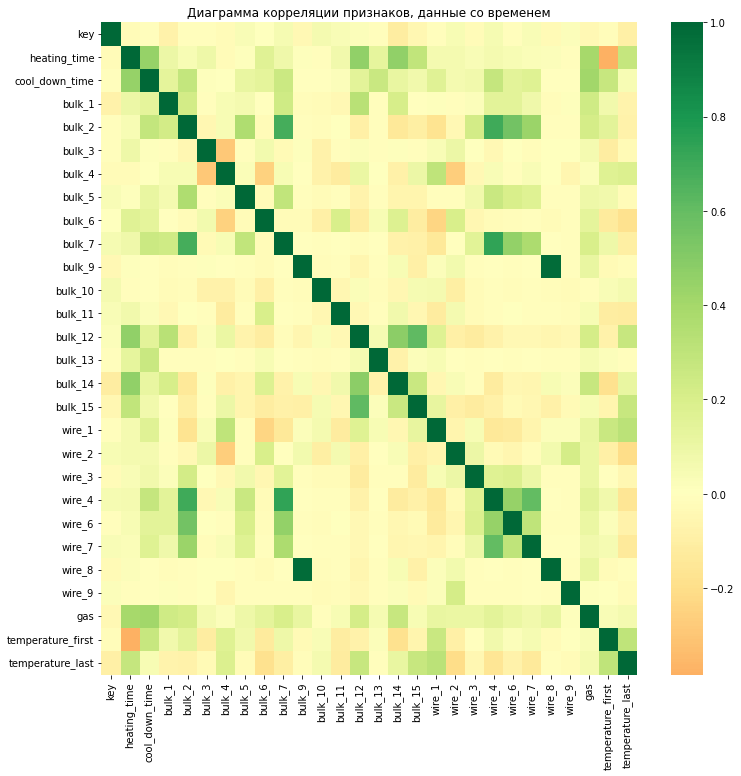

In [71]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_ml_time.corr(), xticklabels=data_ml_time.corr().columns, yticklabels=data_ml_time.corr().columns, cmap='RdYlGn', center=0, annot=False)
plt.title('Диаграмма корреляции признаков, данные со временем')
plt.show()

### Разбиение данных

Разобьем данные на тренировочные и тестовые, удалим столбец key - для модели он не нужен

In [72]:
target = data_ml['temperature_last']
target_time = data_ml_time['temperature_last']

In [73]:
data_ml = data_ml.drop(['temperature_last', 'key'], axis=1)
data_ml_time = data_ml_time.drop(['temperature_last', 'key'], axis=1)

In [74]:
features_train, features_test, target_train, target_test = (
    train_test_split(data_ml, target, test_size=0.25, random_state=RANDOM_SEED, shuffle=True))

In [75]:
features_train_time, features_test_time, target_train_time, target_test_time = (
    train_test_split(data_ml_time, target_time, test_size=0.25, random_state=RANDOM_SEED, shuffle=True))

### Промежуточные выводы

Для обучения моделей было создано две вариации обучающих и тестовых данных - в одной присутствует колонка "активная мощность", во второй "время нагрева". Такой подход связан с тем, что мы незнаем, использует заказчик для расчетов при планировании активную мощность или, что логичнее, время нагрева расплава.

## Исследование задачи

Для решения задачи рассмотрим 4 модели:
- Линейную регрессию с регуляризацией (Lasso)
- Случайный лес
- Light GBM
- CatBoost

Для каждой модели определим функцию, которая подберет параметры, проведет кросс-валидацию, выведет параметры лучшей модели, МАЕ и вернет лучшую модель, обученную на тренировочных данных.

In [76]:
#определим скорер для кросс-валидации

scoring = 'neg_mean_absolute_error'

### Линейная регрессия с регуляризацией

In [77]:
def lasso_get_score(features_train, target_train, cv=5, scoring='neg_mean_absolute_error'):
    lasso = Lasso(random_state=RANDOM_SEED)
    grid_params = {'alpha': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
    lasso2 = GridSearchCV(lasso, grid_params, scoring=scoring)
    
    lasso2.fit(features_train, target_train)
    best_lasso = lasso2.best_estimator_
    print('Параметры лучшей модели:', best_lasso)
    
    #lasso_result = cross_val_score(lasso2.best_estimator_, features_train, target_train, cv=5, scoring=scoring) 
    lasso_result = lasso2.best_score_
    print('MAE для Lasso на кросс-валидации:', abs(lasso_result.mean()))
    
    best_lasso.fit(features_train, target_train)
    feature_importans_lasso = pd.Series(best_lasso.coef_, index=features_train.columns).sort_values(ascending=False)

    plt.figure(figsize=(10 ,5))
    sns.set(style="whitegrid")
    sns.barplot(x=feature_importans_lasso.index, y=feature_importans_lasso);
    plt.title('Значимость признаков', fontsize=12)
    plt.xticks(rotation = 90)
    plt.show()
    
    return best_lasso

**Используем для обучения набор данных с активной мощностью**

Параметры лучшей модели: Lasso(alpha=0.1, random_state=11122)
MAE для Lasso на кросс-валидации: 5.696278340979626


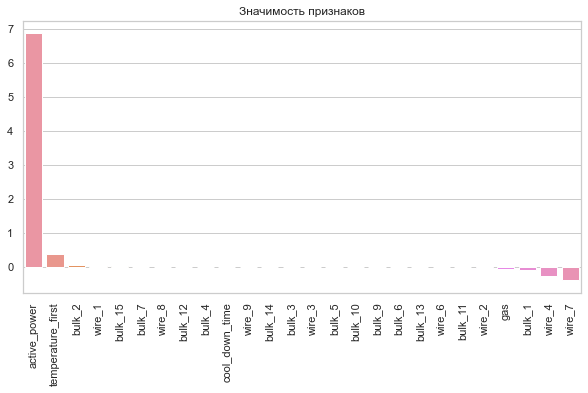

In [78]:
best_lasso = lasso_get_score(features_train, target_train)

**Используем для обучения набор данных с временем нагрева**

Параметры лучшей модели: Lasso(random_state=11122)
MAE для Lasso на кросс-валидации: 5.995547420033225


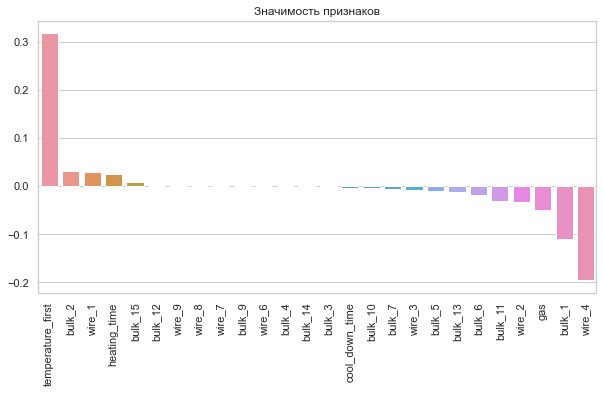

In [79]:
best_lasso_time = lasso_get_score(features_train_time, target_train_time)

### Случайный лес

In [80]:
def forest_get_score(features_train, target_train, cv=5, scoring='neg_mean_absolute_error'):
    forest = RandomForestRegressor(random_state=RANDOM_SEED)
    
    grid_params =  {'n_estimators': range(20, 141, 20),
                'max_depth': range(3, 12)}
    forest2 = GridSearchCV(forest, grid_params, scoring=scoring)
    forest2.fit(features_train, target_train)
    best_forest = forest2.best_estimator_
    print('Параметры лучшей модели', best_forest)
    
    #forest_result = cross_val_score(forest2.best_estimator_, features_train, target_train, cv=5, scoring=scoring)
    forest_result = forest2.best_score_
    print('МАЕ для случайного леса на кросс-валидации:', abs(forest_result.mean()))
    
    best_forest.fit(features_train, target_train)
    feature_importans_forest = pd.Series(best_forest.feature_importances_, index=features_train.columns).sort_values(ascending=False)

    plt.figure(figsize=(10 ,5))
    sns.set(style="whitegrid")
    sns.barplot(x=feature_importans_forest.index, y=feature_importans_forest);
    plt.title('Значимость признаков', fontsize=12)
    plt.xticks(rotation = 90)
    plt.show()
    
    return best_forest

Параметры лучшей модели RandomForestRegressor(max_depth=11, n_estimators=120, random_state=11122)
МАЕ для случайного леса на кросс-валидации: 5.76836221349903


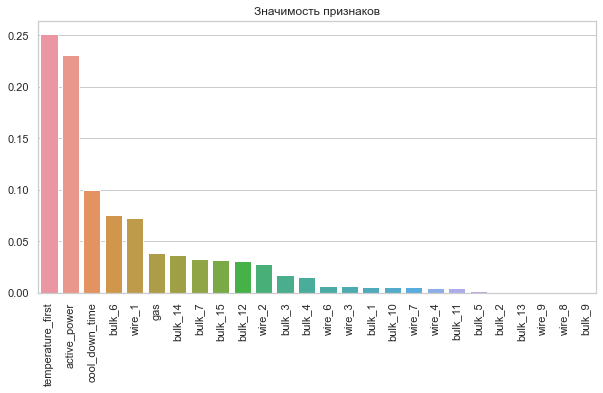

In [81]:
best_forest = forest_get_score(features_train, target_train)

Параметры лучшей модели RandomForestRegressor(max_depth=11, n_estimators=120, random_state=11122)
МАЕ для случайного леса на кросс-валидации: 6.059032764052123


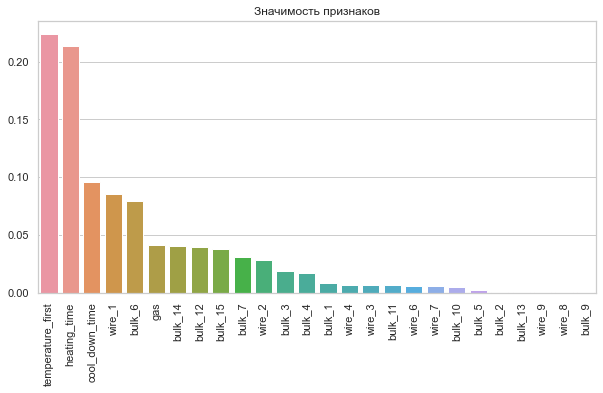

In [82]:
best_forest_time = forest_get_score(features_train_time, target_train_time)

### Light GBM

In [83]:
def lgbm_get_scores(features_train, target_train, cv=5, scoring='neg_mean_absolute_error'):
    lgbm = LGBMRegressor()
    
    grid_params = {'boosting_type': ['goss', 'gbdt'],
                   'n_estimators': [100, 500, 1000, 2000],
                   'learning_rate': [0.01, 0.05],
                   'max_depth': [5, 7, 10, 12, 15]}
    lgbm2 = GridSearchCV(lgbm, grid_params, scoring=scoring)
    lgbm2.fit(features_train, target_train)
    best_lgbm = lgbm2.best_estimator_
    print('Параметры лучшей модели', best_lgbm)

    #lgbm_result = cross_val_score(lgbm2.best_estimator_, features_train, target_train, cv=5, scoring=scoring);
    lgbm_result = lgbm2.best_score_
    print('MAE для LGBM на кросс-валидации:', abs(lgbm_result.mean()))
    
    best_lgbm.fit(features_train, target_train)
    feature_importans_lgbm = pd.Series(best_lgbm.feature_importances_, index=features_train.columns).sort_values(ascending=False)

    plt.figure(figsize=(10 ,5))
    sns.set(style="whitegrid")
    sns.barplot(x=feature_importans_lgbm.index, y=feature_importans_lgbm);
    plt.title('Значимость признаков', fontsize=12)
    plt.xticks(rotation = 90)
    plt.show()
    
    return best_lgbm

Параметры лучшей модели LGBMRegressor(boosting_type='goss', learning_rate=0.01, max_depth=5,
              n_estimators=1000)
MAE для LGBM на кросс-валидации: 5.506753883621699


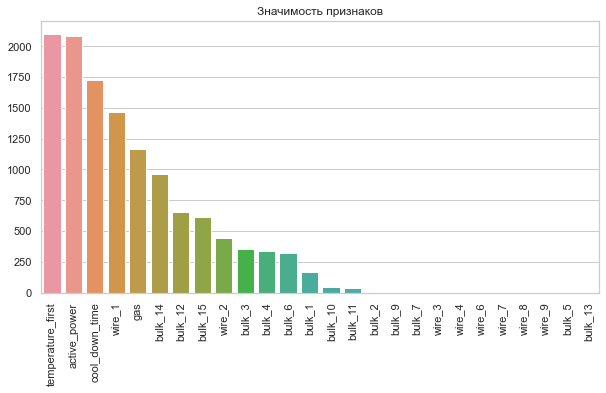

Wall time: 4min 54s


In [84]:
%%time

best_lgbm = lgbm_get_scores(features_train, target_train)

Параметры лучшей модели LGBMRegressor(learning_rate=0.01, max_depth=12, n_estimators=500)
MAE для LGBM на кросс-валидации: 5.884565198605777


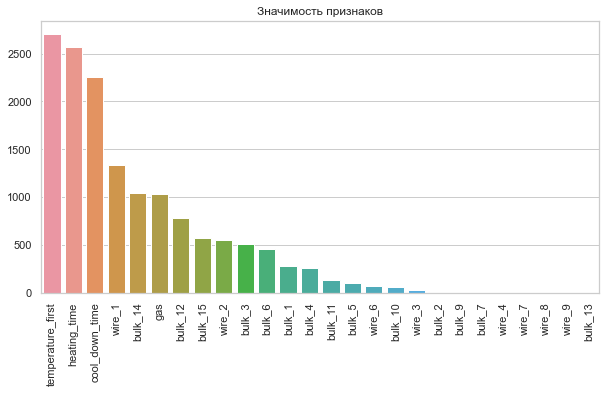

Wall time: 4min 54s


In [85]:
%%time

best_lgbm_time = lgbm_get_scores(features_train_time, target_train_time)

### CatBoost

In [93]:
def cat_get_score(features_train, target_train):
    cat = CatBoostRegressor(silent=True, eval_metric='MAE')
      
    grid = {'learning_rate': [0.01, 0.03, 0.05],
            'depth': [3, 4, 5, 10],
            'l2_leaf_reg': [0.1, 0.3, 0.5]}
    
    #grid = {'learning_rate': [0.03],
    #        'depth': [3],
    #        'l2_leaf_reg': [0.1]}
    
    grid_search_result = cat.grid_search(grid, X=features_train, y=target_train, plot=True)
    print('Параметры лучшей модели', grid_search_result['params'])
    
    best_cat_result = cross_val_score(cat, features_train, target_train, cv=5, scoring=scoring);
    print('MAE для CatBoost на кросс-валидации:', abs(best_cat_result.mean()))
          
    return cat

In [94]:
def cat_get_importance(best_cat):
    
    feature_importans_cat = pd.Series(best_cat.get_feature_importance(), index=features_train.columns).sort_values(ascending=False)

    plt.figure(figsize=(10 ,5))
    sns.set(style="whitegrid")
    sns.barplot(x=feature_importans_cat.index, y=feature_importans_cat);
    plt.title('Значимость признаков', fontsize=12)
    plt.xticks(rotation = 90)
    plt.show()
    

In [95]:
%%time

best_cat = cat_get_score(features_train, target_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 5.855855028
bestIteration = 999

0:	loss: 5.8558550	best: 5.8558550 (0)	total: 960ms	remaining: 33.6s

bestTest = 5.291798229
bestIteration = 999

1:	loss: 5.2917982	best: 5.2917982 (1)	total: 1.97s	remaining: 33.6s

bestTest = 5.286980226
bestIteration = 964

2:	loss: 5.2869802	best: 5.2869802 (2)	total: 3.14s	remaining: 34.5s

bestTest = 5.936965857
bestIteration = 999

3:	loss: 5.9369659	best: 5.2869802 (2)	total: 4.03s	remaining: 32.2s

bestTest = 5.333718465
bestIteration = 998

4:	loss: 5.3337185	best: 5.2869802 (2)	total: 5.02s	remaining: 31.1s

bestTest = 5.29311767
bestIteration = 950

5:	loss: 5.2931177	best: 5.2869802 (2)	total: 5.94s	remaining: 29.7s

bestTest = 6.038384028
bestIteration = 997

6:	loss: 6.0383840	best: 5.2869802 (2)	total: 6.89s	remaining: 28.6s

bestTest = 5.412694389
bestIteration = 998

7:	loss: 5.4126944	best: 5.2869802 (2)	total: 8s	remaining: 28s

bestTest = 5.389706863
bestIteration = 861

8:	loss: 5.3897069	best: 5.2869802 (2)	total: 9.0

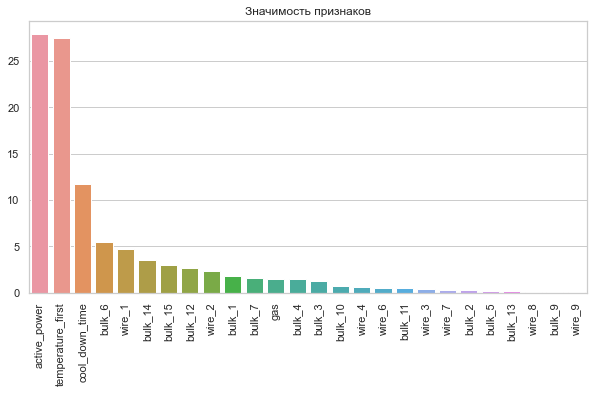

In [96]:
cat_get_importance(best_cat)

In [97]:
best_cat_time = cat_get_score(features_train_time, target_train_time)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 5.9989908
bestIteration = 999

0:	loss: 5.9989908	best: 5.9989908 (0)	total: 981ms	remaining: 34.3s

bestTest = 5.586145172
bestIteration = 999

1:	loss: 5.5861452	best: 5.5861452 (1)	total: 2.04s	remaining: 34.8s

bestTest = 5.601677042
bestIteration = 762

2:	loss: 5.6016770	best: 5.5861452 (1)	total: 2.94s	remaining: 32.4s

bestTest = 6.045188595
bestIteration = 999

3:	loss: 6.0451886	best: 5.5861452 (1)	total: 3.91s	remaining: 31.3s

bestTest = 5.647757709
bestIteration = 984

4:	loss: 5.6477577	best: 5.5861452 (1)	total: 5.18s	remaining: 32.1s

bestTest = 5.642358133
bestIteration = 664

5:	loss: 5.6423581	best: 5.5861452 (1)	total: 6.5s	remaining: 32.5s

bestTest = 6.173233714
bestIteration = 999

6:	loss: 6.1732337	best: 5.5861452 (1)	total: 7.53s	remaining: 31.2s

bestTest = 5.641746133
bestIteration = 999

7:	loss: 5.6417461	best: 5.5861452 (1)	total: 8.58s	remaining: 30s

bestTest = 5.68218293
bestIteration = 963

8:	loss: 5.6821829	best: 5.5861452 (1)	total: 9.5

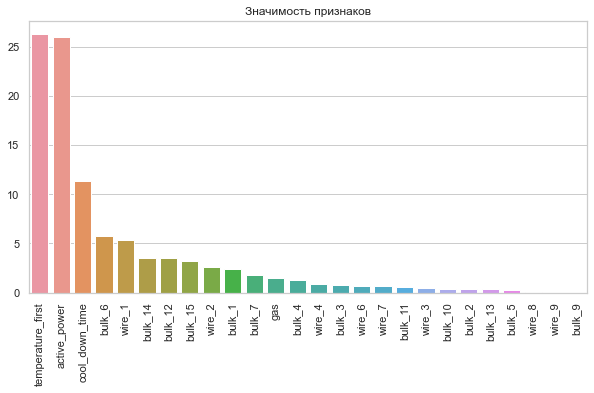

In [98]:
cat_get_importance(best_cat_time)

### Промежуточные выводы

Лучшие результаты на кросс-валидации показал CatBoost - его и будем проверять на финальном тесте.</br>
Графики значимости признаков показывают, что все модели (кроме линейной регресии) "считают" наиболее значимыми начальную температуру, время нагрева/мощность и время остывания. Линейная регрессия настраивается, по сути, на один параметр и не может учесть более сложные взаимосвязи с загружаемыми материалами.

## Тестирование модели

Протестируем модель, которая опирается на время нагрева и остывания. </br>
Этот подход я считаю более правильным, т.к. активная мощность фиксируется уже после завершения процесса нагрева. Её точное значение нельзя спланировать до начала процесса, поэтому планирование времени нагрева и простоя представляется более реалистичным для использования.

In [99]:
prediction_time = best_cat_time.predict(features_test_time)

In [100]:
print('Результат на тестовой выборке (время нагрева): ', mean_absolute_error(target_test, prediction_time))

Результат на тестовой выборке (время нагрева):  5.6826360208084115


## Вывод

В ходе работы над проектом
- подготовлены данные - именены типы данных и названия колонок
- проведён исследовательский анализ данных, построены гистограммы, рассмотрены взаимосвязи величин
- данные подготовлены для построения модели, сведены в один датасет, разделены на тестовую и тренировочную выборки; рассмотрены два варианта планирования процесса заказчиком
- обучены 4 регрессионные модели - Lasso, Random Forest, LGBM, CatBoost
- проведено финальное тестирование

Лучший результат на кросс-валидации показал CatBoostRegressor. Для тестирования была выбрана модель, когда планирование легирования осуществляется через регулировку времени нагрева и подачи. MAE на кросс-валидации 5,77, на тестовой выборке - 5,68, т.е при прогнозировании температуры модель ошибается в среднем на 5,7 - 5,8 градуса (в рамках задачи измерения ведутся с округлением до целого, поэтому можно сказать, что модель ошибается на 6 градусов.

## Итоговый отчёт

### Аннотация

В ходе работы решалась задача разработки модели предсказания финальной температуры процесса легирования сталей. Предполагается, что использование этой модели позволит более качественно спланировать технологический процесс, уменьшить количество итераций нагрева и тем самым оптимизировать стоимость производства путем снижения затрат электроэнергии. </br>
Изучены данные о параметрах, сопутствующих процессу легирования, проведена очистка данных и отбор признаков. Решена задача регрессии. Рассмотрены модели Lasso, RandomForest, LGBM и CatBoost. Использована метрика MAE и оценка эффективности на кросс-валидации. Выбрана модель CatBoost, метрика на тестовой выборке - 5,7. 

### Постановка проблемы

Оптимизация производственных процессов является неотъемлемым элементом для любого предприятия независимо от его этапа развития. Один из основных способов оптимизации - снижение затрат на изготовление продукции благодаря подбору оптимальных параметров производственного процесса, в том числе и с помощью моделей машинного обучения.</br>
</br>
В данной работе основной целью являлась разработка модели, позволяющей оптимизировать процесс легирования стали через снижение энергопотребления.</br>
</br>
Процесс введения легирующих добавок в подготовленный расплав сопровождается разогревом этого расплава. Затем в него добавляют необходимые вещества, продувают сплав инертным газом и перемешивают. После этого - проводят измерения температуры и химического состава. Такой цикл может повторяться несколько раз до того момента, как будут достигнуты целевые параметры, одним из которых является финальная температура расплава.</br>
Необходимость многократного прогрева  в попытке добиться оптимальных параметров повышает расходы предприятия на электроэнергию. И в этой ситуации наличие модели прогнозирования, которая поможет заранее подобрать и спланировать параметры технологического процесса, позволило бы свести количество итераций нагрева к возможному минимуму, снизив тем самым расходы.</br>
Наша задача  состояла в том, чтобы на имеющихся исторических данных построить модель, которая будет прогнозировать температуру конечного расплава в зависимости от заданных параметров производственного процесса.</br>

Рисунок 1. Вариации количества нагревов в процессе легирования.

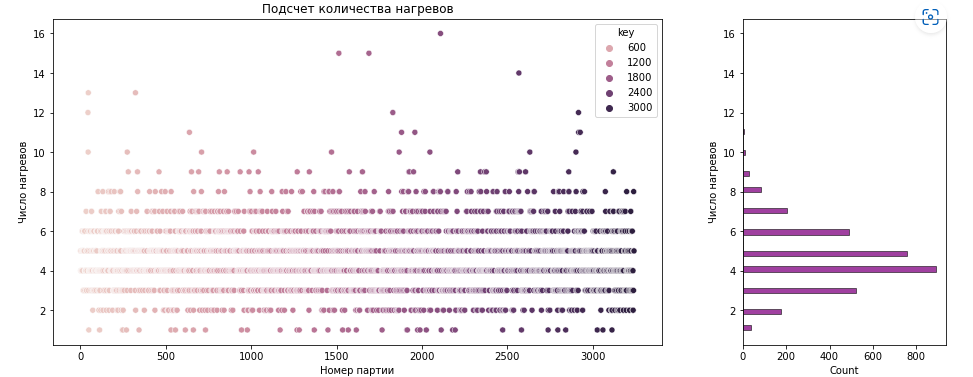

### Данные

Для разработки модели были использованы данные о разогреве, объеме использованных легирующих веществ и газа, а также данные об измерениях температуры. Мы провели анализ полученных данных и обнаружили следующие особенности:
- количество измерений температуры, а также эпизодов нагрева для партии может варьироваться от 1 до 16
- некоторые партии содержат лишь одно измерение температуры (их пришлось исключить из рассмотрения ввиду недостаточности данных)
- и начальная, и финальная температуры находятся в достаточно узком диапазоне от 1500 до 1704 С, при этом в соответствии с техзаданием пришлось исключить бракованные партии, в которых она опускалась ниже 1500 С.
- в файлах данных имеется фактическая рассинхронизация времён нагревов и замеров температур. Согласно уточнению от заказчика, этот фактор можно игнорировать, считая первый и последний замер температуры соответствующим началу и концу легировния
- согласно временным меткам легирование некоторых партий происходит параллельно - этот фактор мы также будем игнорировать, рассматривая каждую партию изолированно
- и сыпучие, и проволочные материалы из разных бункеров/трайбов используются неравномерно - одни добавляются в большое количество партий, другие - только в единицы
- суммарное время нагрева линейно связано с активной мощностью с коэффициентом корреляции 0,978
- в части случаев старотовая температура расплава оказывается выше, чем целевая

Всего были доступны данные о легировании 3214 партий, однако после очистки данных для построения модели было использовано 2325 партий.

Рисунок 2. Разброс температур до начала процесса и после его окончания.
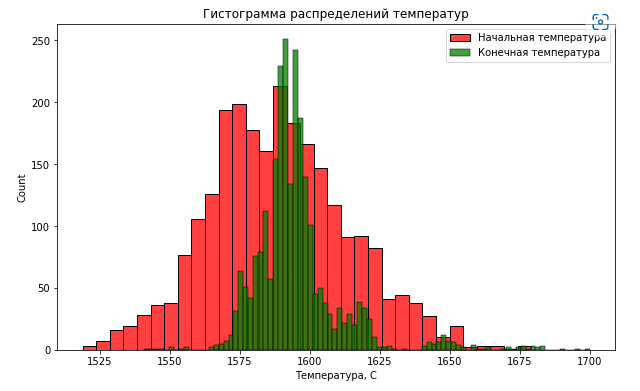

### Отбор признаков

Для разработки модели нам были отобраны признаки, которые:

- позволяют учесть все особенности производственного процесса
- позволяют технологам планировать эксперимент заранее
- не дублируют друг друга

В задаче планируется оптимизировать энергопотребление - то есть активную мощность, которая затрачивается на процесс (реактивная мощность в данном случае - неизбежные издержки и ее оптимизация лежит за пределами решаемой задачи). Также необходимо учесть время остывания расплава, когда нагрев не идет, но процесс легирования еще не закончен.</br>
</br>
Важно отметить, что величины активной и реактивной мощности это, как правило, измеряемые величины, а не регулируемые и их точное значение доступно уже по факту завершения процесса легирования. Можно запланировать потребить определенную мощность, но регулироваться в этом случае будут всё равно другие величины - сила тока, величина напряжения и (как в нашем случае) время нагрева. Поэтому логично включать в перечень признаков не саму мощность, а регулируемые параметры.</br>
</br>
При изучении данных мы выяснили, что активная мощность линейно зависит от чистого времени нагрева, поэтому при отборе признаков эти величины могут быть взаимозаменяемы. При построеннии модели на временных признаках технолог сможет планировать эксперимент, включая в него предполагаемое время нагрева и предполагаемое время простоя для замеров (например, если по техпроцессу нельзя вводить все легирующие добавки разом).</br>
</br>
Рисунок 3. Зависимость активной мощности и длительности нагрева.</br>

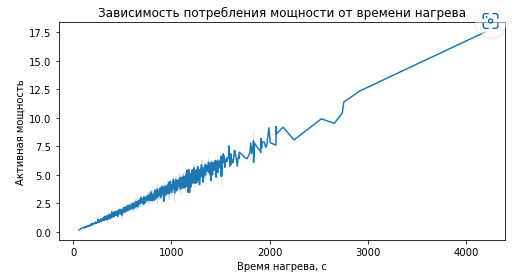

Для решения задачи было использовано два набора, в один из которых вошла активная мощность, а в другой - чистое время нагрева.</br>
</br>
Таким образом, в перечень признаков мы включили:

- данные о суммарном объеме сыпучих матералов, которые предполагается добавить к расплаву
- данные о суммарном объеме проволочных материалов
- данные об объеме газа, который будет использоваться для продувки
- начальную температуру расплава
- чистое время нагрева // активную мощность
- количество планируемых нагревов
- чистое время остывания

Данные о партиях были разбиты на тренировочную и тестовую выборки в соотношении 3:1.

### Выбор модели

Для решения задачи было рассмотрено 4 модели:

- Lasso
- Случайный лес
- Light GBM
- CatBoost

В качестве метрики задачи была выбрана средняя абсолютная ошибка MAE (mean absolute error):</br>

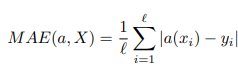

Эта величина суммирует модули отклонений предсказанных моделью величин от "правильных ответов" и усредняет их по количеству предсказанных величин. Другими словами, метрика показывает на сколько градусов в среднем модель ошибается при предсказании температуры.</br>

Для каждой модели были опробованы оба набора данных. Оценка качества модели проводилась на кросс-валидации, для подбора гиперпараметров была использована функция Grid Search.</br>
</br>
**Lasso** принадлежит к классу линейных моделей с регуляризацией. Линейная модель может быть вкратце описана формулой: 
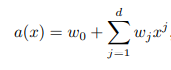
где $ w_0$ - свободный коэффициент, $x^j$ - признаки, а $w_j$ - их веса. Задача сводится к подбору коэффициентов (весов) в многомерном пространстве признаков таким образом, чтобы отклонения функции потерь (то есть ошибки в предсказаниях) были минимальны. Регуляризация является дополнительным параметром, который "штрафует" модель за слишком большие коэффициенты и не позволяет ей переобучаться (то есть подстраиваться под обучающую выборку).</br>
В случае решаемой задачи линейная модель оказалась неэффективна, поскольку не смогла найти нелинейные взаимосвязи между финальной температурой и добавлением легирующих материалов.</br>
</br>
**Случайный лес** представляет собой усреднение решений большого количества решающих деревьев, обученных на различных подвыборках из обучающего набора данных. В нашем задаче оптимальный результат был получен на наборе из 120 решающих деревьев с максимальной глубиной 11.</br>
</br> **Light GBM** и **Catboost** - это модели с двумя разными вариантами реализации градиентного бустинга. Градиентный бустинг относится к классу ансамблевых алгоритмов машинного обучения. Его суть сводится к построению композиции, в которой алгоритмы выстраиваются последовательно, один за другим, и каждый последующий реализуется так, чтобы исправлять ошибки уже построенной композиции. Функция потерь (т.е. функция, отражающей ошибку) оптимизируется с помощью градиентного спуска. В качестве базового алгоритма чаще всего выступают решающие деревья.</br>
</br>
Для набора данных, включающих в себя активную мощность, были получены следующие значения МАЕ:</br>
Случайный лес - 5.8</br>
Light GBM - 5.5</br>
CatBoost - 5.45</br>
</br>
Для набора данных, включающих в себя время нагрева, были получены следующие значения МАЕ:</br>
Случайный лес - 6.1 </br>
Light GBM - 5.9</br>
CatBoost - 5.7</br>
</br>
В качестве финальной была выбрана модель CatBoost для набора данных с временем нагрева. Этот подход представляется более верным, т.к. активная мощность фиксируется уже после завершения процесса нагрева и её точное значение нельзя спланировать до начала процесса. А значит планирование времени нагрева и простоя представляется более реалистичным для использования.</br>

Рисунок 4. Влияние признаков на результат предсказания для выбранной финальной модели.</br>
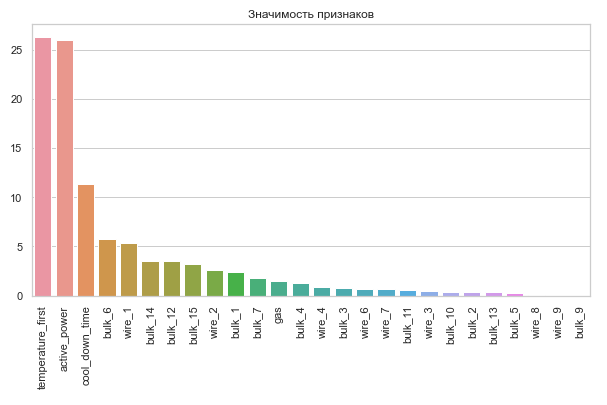

### Апробация итогового решения

Тестирование было проведено на тестовой выборке из 581 партии. MAE на на тестовой выборке показало значение 5,68 - т.е при прогнозировании температуры модель ошибается в среднем на 5,7 градуса. Поскольку в рамках задачи измерения ведутся с округлением до целого, поэтому можно сказать, что полученная модель ошибается на 6 градусов.

### Заключение

В ходе работы был изучен процесс легирования сталей, рассмотрены особенности нагрева партий, подачи материала, измерений температуры. Был проведен исследовательский анализ данных, их очистка и подготовка к построению модели. Было рассмотрено два варианта планирования технологического процесса заказчиком - с использованием активной мощности и времени нагрева. Разбиение данных для обучения и теста проводилось в соотношении 3:1. Были изучены 4 модели - Lasso, Random Forest, LGBM, CatBoost; проведен поиск гиперпараметров и оценка метрики на кросс-валидации. В качестве метрики использовалась МАЕ. Ансамблевые методы решения показали себя наиболее эффективными для решения данной задачи. В качестве финальной модели был выбран CatBoost.</br>

После согласования с заказчиком возможна дальнейшая доработка модели путем исключения признаков с низкой значимостью.